# Base loads

In [1]:
!pip install pyro-ppl==1.3.0

KeyboardInterrupt: ignored

In [0]:
!nvidia-smi

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import folium
import datetime

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual


import numpy as np
import folium
from folium import plugins
import matplotlib
import seaborn as sns

In [0]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load Git code

In [0]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling, normalizing_flow_factory, conditional_normalizing_flow_factory
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples, searchlog_semisup_day_split, circle_transform, get_split_idx_on_day
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, approx_rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

from DEwNF.utils import calculate_cap_of_model
from DEwNF.utils import calculate_cap_of_hubs
from DEwNF.utils import calculate_cap_of_random
from DEwNF.utils import calculate_cap_of_perfect_model

# Create results plot for different contexts with one weather variable

In [0]:
three_way_comp_path = os.path.join(root_path, "results/donkey_republic/searchlog/3_way_comp_lr_deep")

In [0]:
loaded_dicts = {}

folders = os.listdir(three_way_comp_path)
for run_name in folders:
    run_path = folder = os.path.join(three_way_comp_path, run_name)
    model_names = os.listdir(run_path)
    loaded_dicts[run_name] = {}
    for model_name in model_names:
        model_path = os.path.join(run_path, model_name)
        file = os.path.join(model_path)
        with open(file, 'rb') as f:
            loaded_dict = pickle.load(f)
        loaded_dicts[run_name][model_name] = loaded_dict
            
runs = list(loaded_dicts.keys())
#runs = ['run2', 'run3']
models = list(loaded_dicts[runs[0]].keys())

results_dict = {}

for model in models:
    results_dict[model] = {}
    runs_arr = []
    for run in runs:
        runs_arr.append(loaded_dicts[run][model]['logs']['test'][-1])
    results_dict[model]['mean'] = np.mean(runs_arr)
    results_dict[model]['max'] = np.max(runs_arr)
    results_dict[model]['min'] = np.min(runs_arr)

In [0]:
loaded_dicts[run]['unconditioinal.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 5,
 'c_net_h_dim': 24,
 'clipped_adam': 10.0,
 'epochs': 2000,
 'flow_depth': 24,
 'initial_lr': 0.0001,
 'l2_reg': None,
 'lr_decay': 0.996,
 'obs_cols': ['user_location_latitude', 'user_location_longitude'],
 'problem_dim': 2}

In [0]:
loaded_dicts[run]['conditional_no_weather.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 5,
 'c_net_h_dim': 24,
 'clipped_adam': 10.0,
 'context_cols': ['hour_sin', 'hour_cos'],
 'context_dim': 2,
 'context_n_depth': 5,
 'context_n_h_dim': 24,
 'epochs': 2000,
 'flow_depth': 24,
 'initial_lr': 0.0001,
 'l2_reg': None,
 'lr_decay': 0.996,
 'obs_cols': ['user_location_latitude', 'user_location_longitude'],
 'problem_dim': 2,
 'rich_context_dim': 6,
 'semisup_context_cols': ['hour_sin', 'hour_cos']}

In [0]:
loaded_dicts[run]['conditional_w_weather.pickle']['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 5,
 'c_net_h_dim': 24,
 'clipped_adam': 10.0,
 'context_cols': ['hour_sin', 'hour_cos', 'rain'],
 'context_dim': 3,
 'context_n_depth': 5,
 'context_n_h_dim': 24,
 'epochs': 2000,
 'flow_depth': 24,
 'initial_lr': 0.0001,
 'l2_reg': None,
 'lr_decay': 0.996,
 'obs_cols': ['user_location_latitude', 'user_location_longitude'],
 'problem_dim': 2,
 'rich_context_dim': 6,
 'semisup_context_cols': ['hour_sin', 'hour_cos'],
 'sup_context_context_cols': ['rain']}

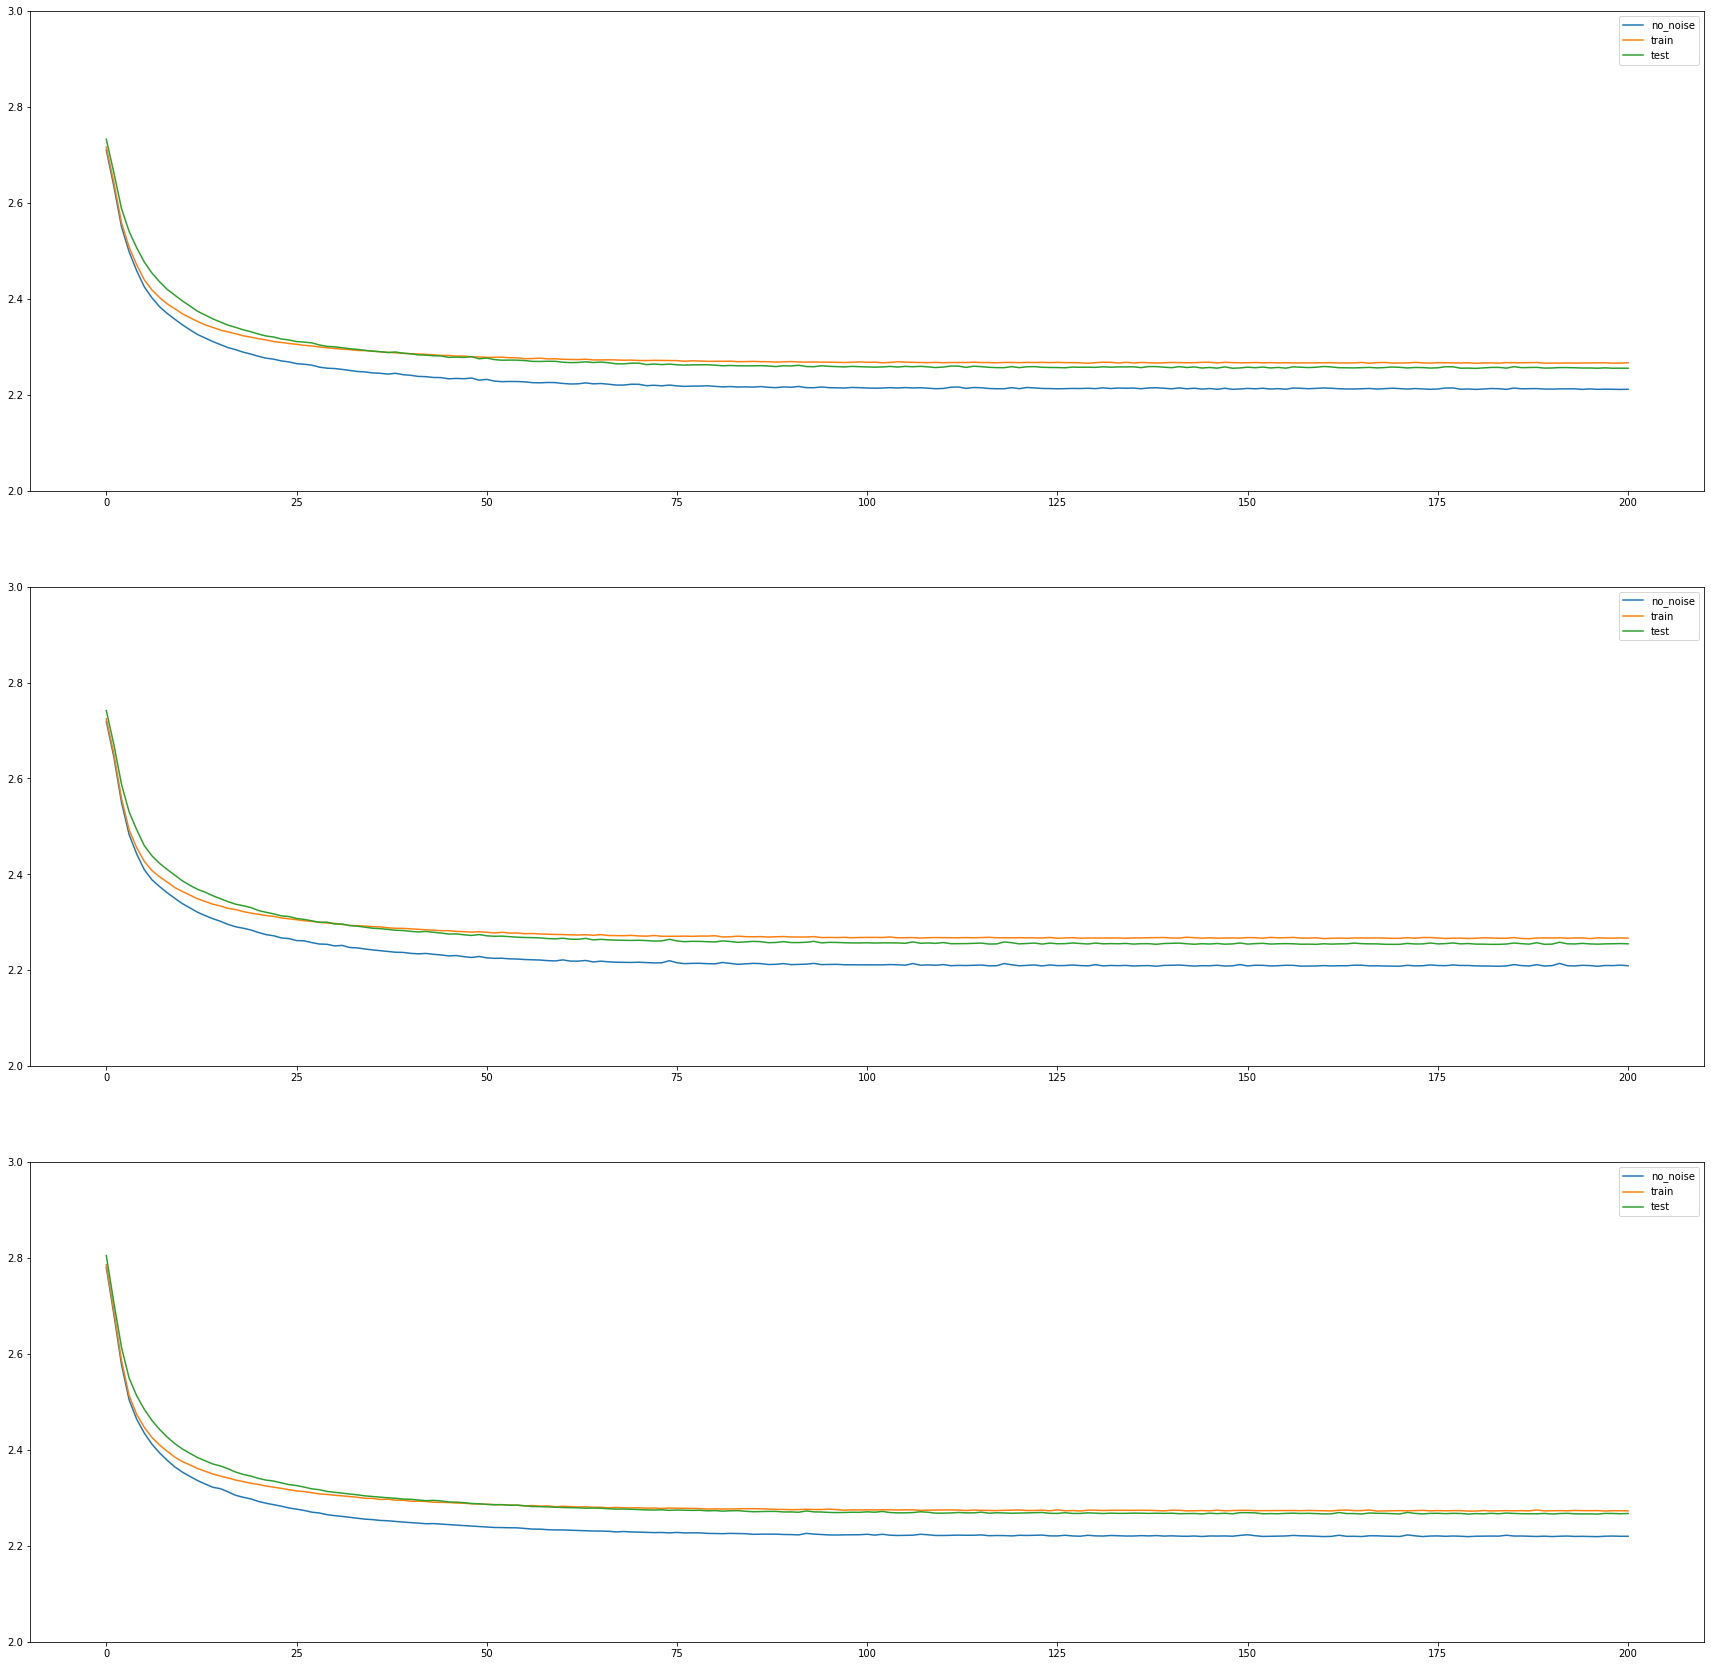

In [0]:
fig, ax = plt.subplots(3, figsize=(30,30))
for i, run in enumerate(runs):
    ax[i].set_ylim((2,3))
    ax[i].plot(loaded_dicts[run]['unconditioinal.pickle']['logs']['no_noise_losses'])
    ax[i].plot(loaded_dicts[run]['unconditioinal.pickle']['logs']['train'])
    ax[i].plot(loaded_dicts[run]['unconditioinal.pickle']['logs']['test'])
    ax[i].legend(['no_noise', 'train', 'test'])

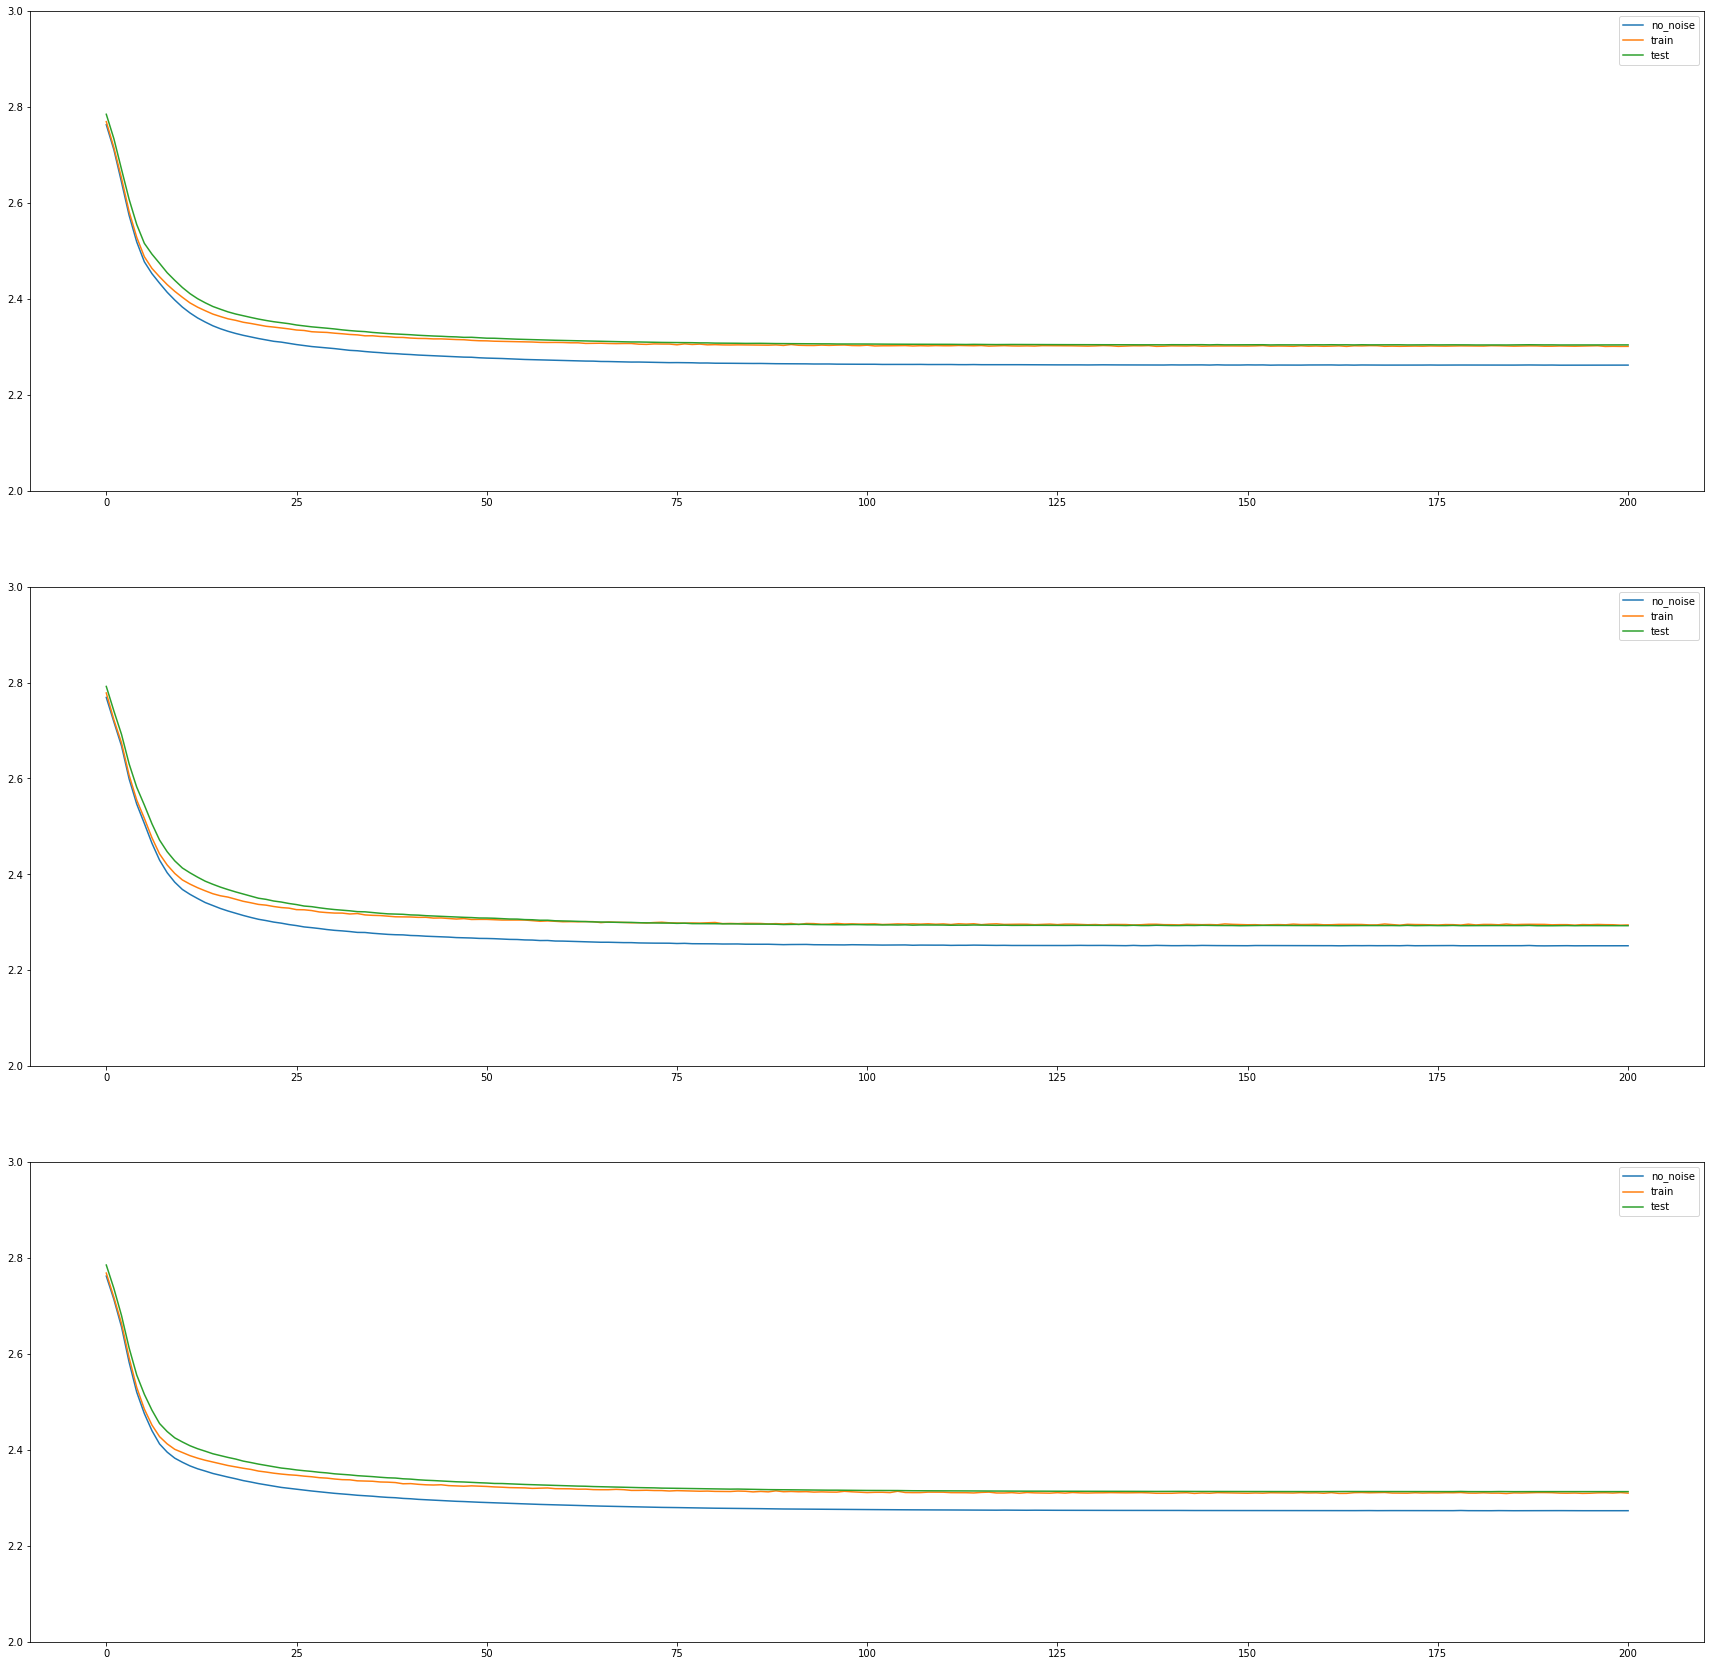

In [0]:
fig, ax = plt.subplots(3, figsize=(30,30))
for i, run in enumerate(runs):
    ax[i].set_ylim((2,3))
    ax[i].plot(loaded_dicts[run]['conditional_no_weather.pickle']['logs']['no_noise_losses'])
    ax[i].plot(loaded_dicts[run]['conditional_no_weather.pickle']['logs']['train'])
    ax[i].plot(loaded_dicts[run]['conditional_no_weather.pickle']['logs']['test'])
    ax[i].legend(['no_noise', 'train', 'test'])

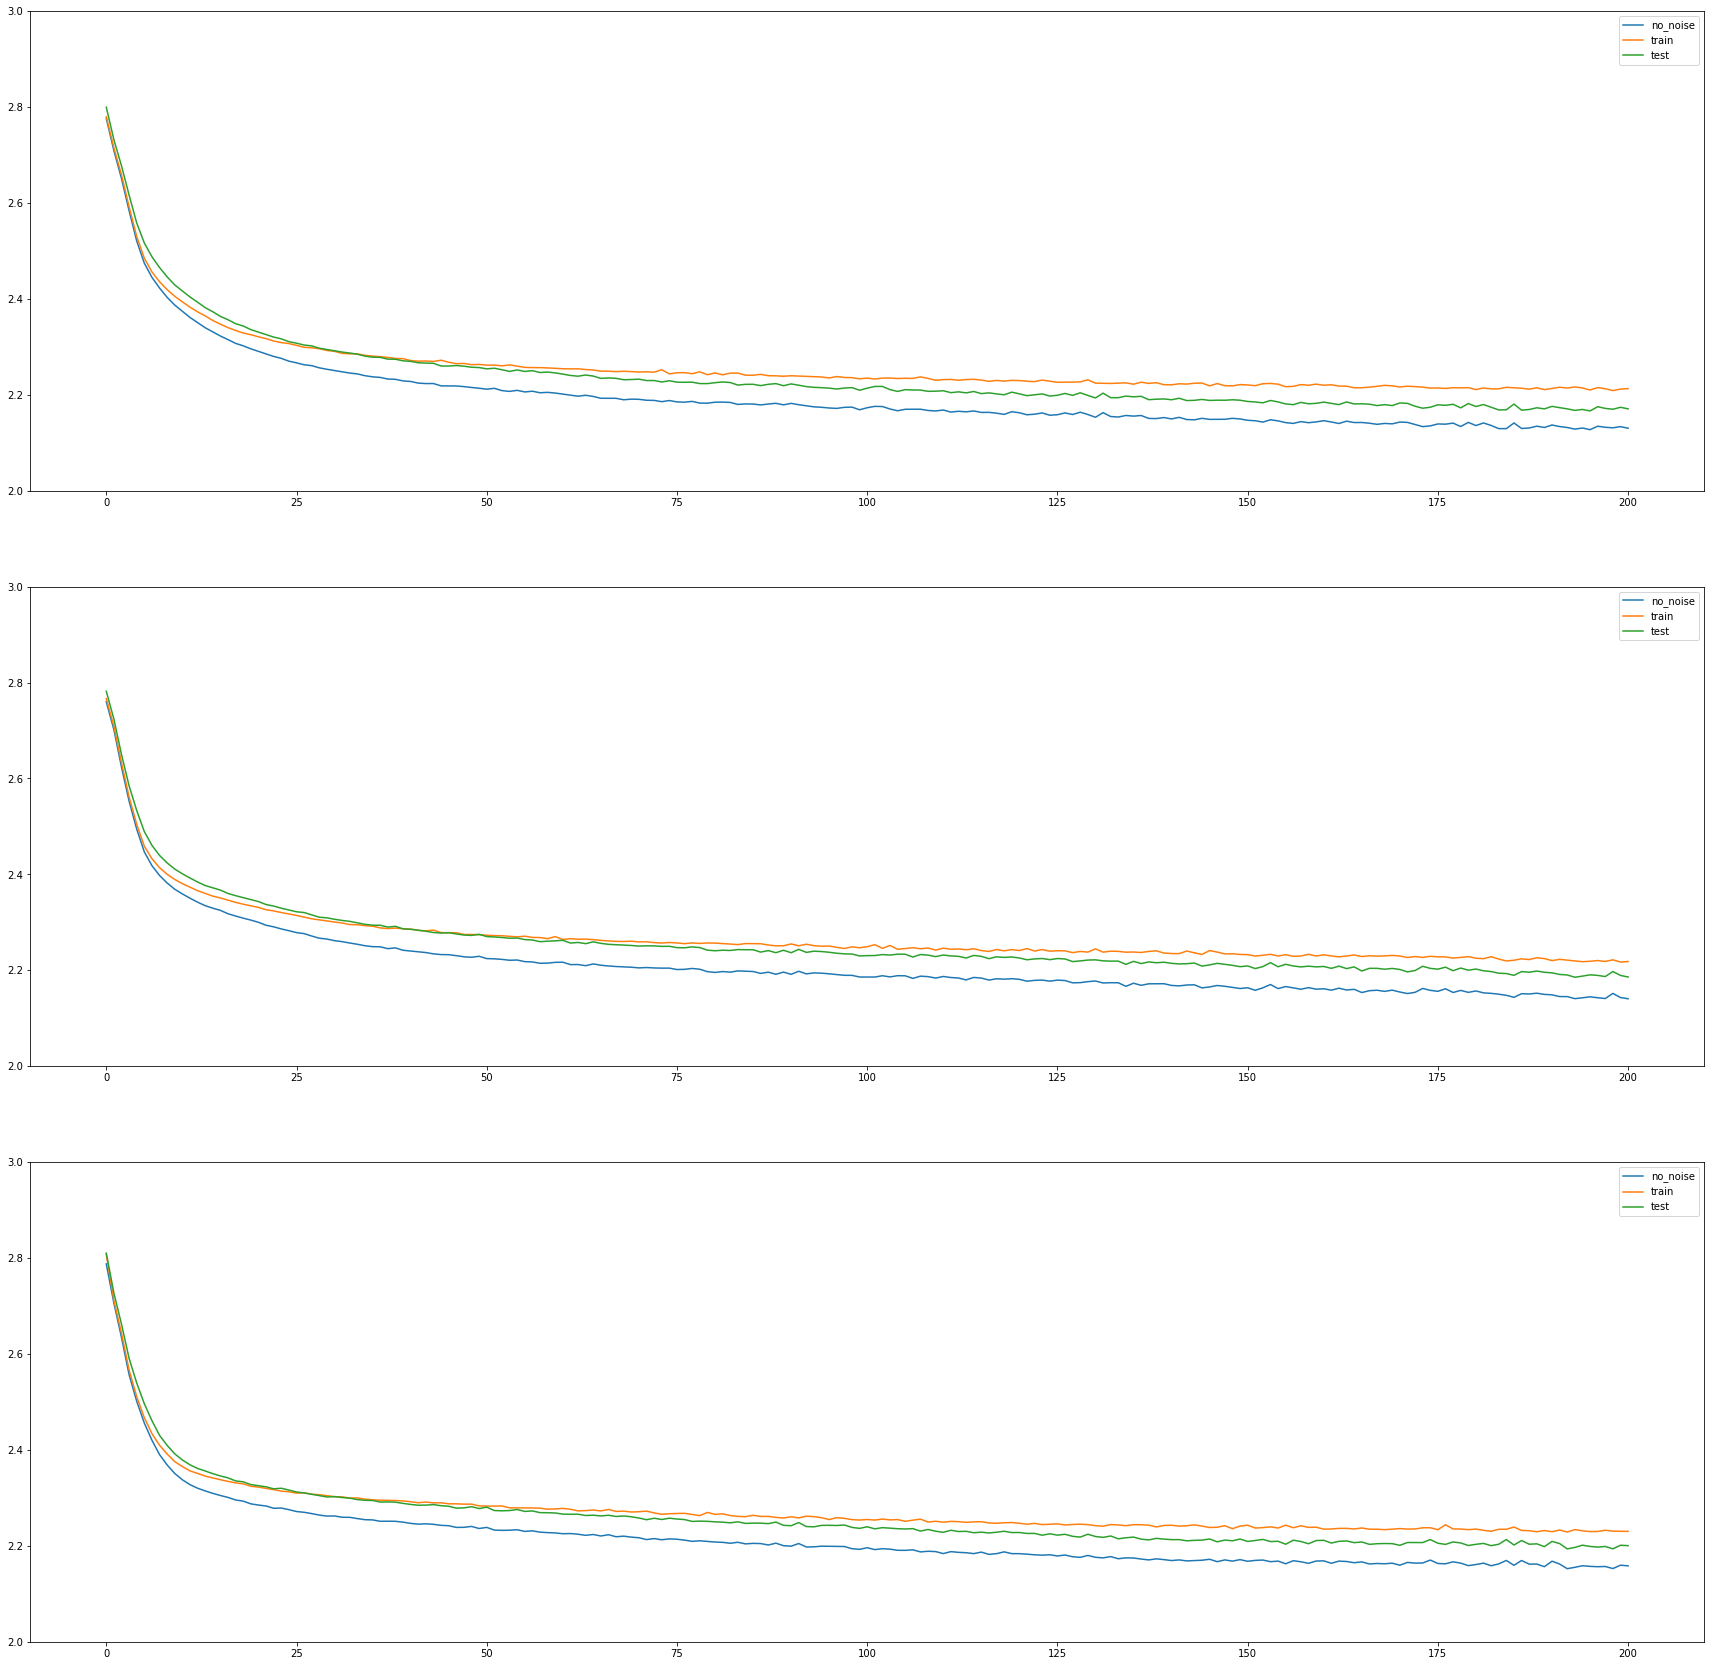

In [0]:
fig, ax = plt.subplots(3, figsize=(30,30))
for i, run in enumerate(runs):
    ax[i].set_ylim((2,3))
    ax[i].plot(loaded_dicts[run]['conditional_w_weather.pickle']['logs']['no_noise_losses'])
    ax[i].plot(loaded_dicts[run]['conditional_w_weather.pickle']['logs']['train'])
    ax[i].plot(loaded_dicts[run]['conditional_w_weather.pickle']['logs']['test'])
    ax[i].legend(['no_noise', 'train', 'test'])

In [0]:
models = ['unconditioinal.pickle',
 'conditional_no_weather.pickle',
 'conditional_w_weather.pickle']
means = np.array([results_dict[model]['mean'] for model in models])
mins = np.array([results_dict[model]['min'] for model in models])
maxs = np.array([results_dict[model]['max'] for model in models])
model_names = [model.split('.')[0] for model in models]
upper_err = maxs - means
lower_err = means - mins

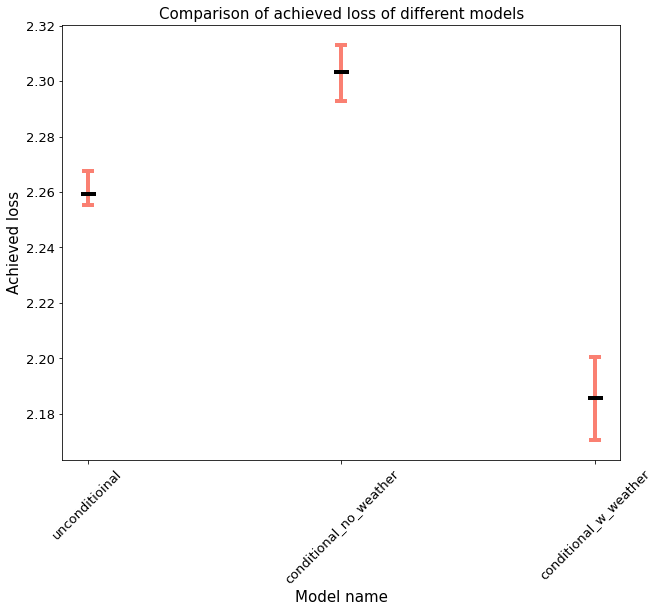

In [0]:
plt.figure(figsize=(10,8))
plt.errorbar(model_names, means, yerr=[lower_err, upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='salmon'
                )
plt.title("Comparison of achieved loss of different models", fontsize=15)
plt.xticks(model_names, model_names, rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Model name', fontsize=15)
plt.ylabel('Achieved loss', fontsize=15)
plt.show()

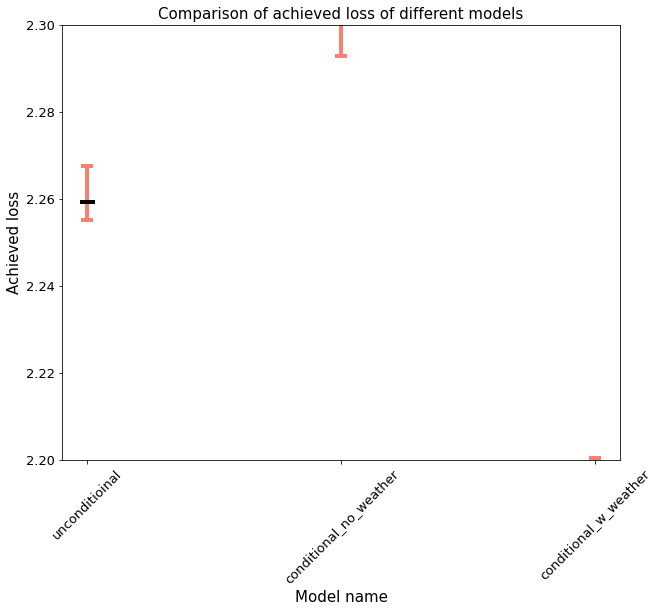

In [0]:
plt.figure(figsize=(10,8))
plt.ylim(2.2,2.3)
plt.errorbar(model_names, means, yerr=[lower_err, upper_err],
             linestyle="",
             marker='_',
             color='black',
             mew=4,
             markersize=15,
             capsize=6,
             elinewidth=4,
             ecolor='salmon'
                )
plt.title("Comparison of achieved loss of different models", fontsize=15)
plt.xticks(model_names, model_names, rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Model name', fontsize=15)
plt.ylabel('Achieved loss', fontsize=15)
plt.show()

# Compare the unconditional, no weather and 1 weather models

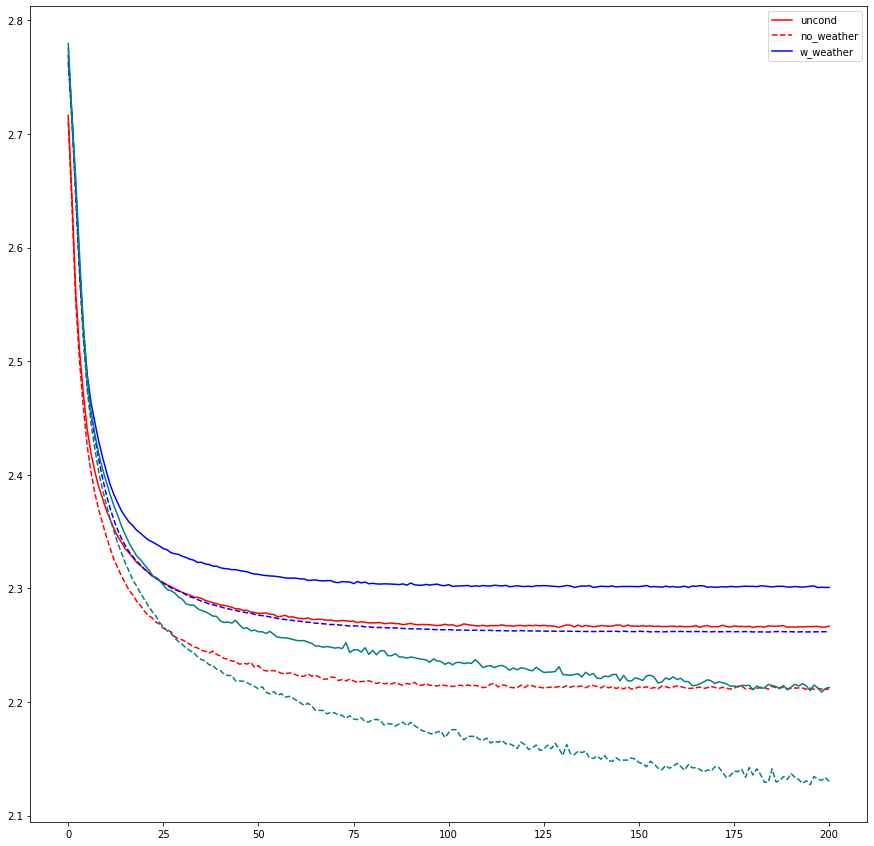

In [0]:
plt.figure(figsize=(15,15))
plt.plot(loaded_dicts['run3']['unconditioinal.pickle']['logs']['train'], c = 'red')
plt.plot(loaded_dicts['run3']['unconditioinal.pickle']['logs']['no_noise_losses'], c = 'red', linestyle = '--')
plt.plot(loaded_dicts['run3']['conditional_no_weather.pickle']['logs']['train'], c = 'blue')
plt.plot(loaded_dicts['run3']['conditional_no_weather.pickle']['logs']['no_noise_losses'], c = 'blue', linestyle = '--')
plt.plot(loaded_dicts['run3']['conditional_w_weather.pickle']['logs']['train'], c = 'teal')
plt.plot(loaded_dicts['run3']['conditional_w_weather.pickle']['logs']['no_noise_losses'], c = 'teal', linestyle = '--')

plt.legend(['uncond', 'no_weather', 'w_weather'])

# CAP Comparison

## Load datasets

In [0]:
donkey_folder = os.path.join(dataset_folder, 'Donkey_republic')
csv_path = os.path.join(donkey_folder, 'CoordinateSearchlog_simple.csv')
donkey_df = pd.read_csv(csv_path, parse_dates=[4, 11])


In [0]:
hubs_path = os.path.join(donkey_folder, "Hubs.csv")
hubs_df = pd.read_csv(hubs_path, parse_dates=[0])
hubs_df['deleted'] = ~hubs_df.deleted_at.isnull()


In [0]:
extra_path = os.path.join(donkey_folder, 'UnsupervisedCoordinateSearchlog.csv')
extra_df = pd.read_csv(extra_path, parse_dates=[4,12])

In [0]:
hubs_ranking_path = os.path.join(donkey_folder, 'HubsRankedByRentals.csv')
ranked_hubs_df = pd.read_csv(hubs_ranking_path, index_col=0)


## Load models

In [0]:
results_dict

{'conditional_no_weather.pickle': {'max': 2.3130982707285557,
  'mean': 2.3033163105674306,
  'min': 2.2929873589864487},
 'conditional_w_weather.pickle': {'max': 2.2004581848980163,
  'mean': 2.1856652412510478,
  'min': 2.1705125602472757},
 'unconditioinal.pickle': {'max': 2.267515913139145,
  'mean': 2.2593033472164015,
  'min': 2.2551949086686225}}

In [0]:
loaded_dicts['run3']['conditional_no_weather.pickle']['logs']['test'][-1]

2.303863301987287

In [0]:
uncond_flow = loaded_dicts['run3']['unconditioinal.pickle']['model']
no_weather_flow = loaded_dicts['run3']['conditional_no_weather.pickle']['model']
w_weather_flow = loaded_dicts['run3']['conditional_w_weather.pickle']['model']

In [0]:
obs_cols = loaded_dicts['run3']['unconditioinal.pickle']['settings']['obs_cols']

weather_semisup_context_cols = loaded_dicts['run3']['conditional_w_weather.pickle']['settings']['semisup_context_cols']
weather_sup_context_cols = loaded_dicts['run3']['conditional_w_weather.pickle']['settings']['sup_context_context_cols']

no_weather_semisup_context_cols = loaded_dicts['run3']['conditional_no_weather.pickle']['settings']['semisup_context_cols']
batch_size = loaded_dicts['run3']['conditional_w_weather.pickle']['settings']['batch_size']

# Only on hour

### Setup CAP data - SET CONTEXT HERE

In [0]:
train_idx, test_idx = get_split_idx_on_day(donkey_df)

In [0]:
train_dataloader, test_dataloader, extra_dataloader, obs_scaler, semisup_context_scaler, sup_context_scaler = searchlog_semisup_day_split(sup_df=donkey_df,
                                                                                                                                          unsup_df=extra_df,
                                                                                                                                          obs_cols=obs_cols,
                                                                                                                                          semisup_context_cols=weather_semisup_context_cols,
                                                                                                                                          sup_context_cols=weather_sup_context_cols,
                                                                                                                                          batch_size=batch_size,
                                                                                                                                          cuda_exp=True)

In [0]:
no_weather_semisup_context_cols

['hour_sin', 'hour_cos']

In [0]:
hour_test = 8
rain = False

hour_cos, hour_sin = circle_transform(hour_test,24)
scaled_context_no_weather = semisup_context_scaler.transform([[hour_sin, hour_cos]])
scaled_context_w_weather = np.array([np.concatenate((scaled_context_no_weather[0], [rain]))])

In [0]:
test_df = donkey_df.loc[test_idx]
context_idx = (test_df.merge_date.dt.hour == hour_test)
context_filtered_df = test_df.loc[context_idx]

In [0]:
len(context_filtered_df)

4735

In [0]:
# Map settings
initial_location = [55.6775757, 12.579571639999999]
lower_left = [55.578855, 12.368879]
upper_right = [55.785292, 12.746675]
bounds = [lower_left, upper_right]

In [0]:
# Condition conditional flows
conditioned_no_weather_flow = no_weather_flow.condition(torch.tensor(scaled_context_no_weather).float().cuda())
conditioned_w_weather_flow = w_weather_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())

In [0]:
_, _, perfect_covered_arr = calculate_cap_of_perfect_model(shape = (800,800), bounds=bounds, df=context_filtered_df)

640000it [44:38, 238.97it/s]
640000it [01:09, 9213.44it/s]


In [0]:
_, _, _, conditional_w_weather_covered_arr = calculate_cap_of_model(shape=(800,800), bounds=bounds, dist=conditioned_w_weather_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

640000it [41:58, 254.07it/s]


In [0]:
_, _, _, conditional_no_weather_covered_arr = calculate_cap_of_model(shape=(800,800), bounds=bounds, dist=conditioned_no_weather_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

640000it [41:44, 255.52it/s]


In [0]:
_, _, _, unconditional_covered_arr = calculate_cap_of_model(shape=(800,800), bounds=bounds, dist=uncond_flow.dist, df=context_filtered_df, obs_scaler=obs_scaler) 

640000it [41:39, 256.08it/s]


In [0]:
_, _, _, hubs_covered_arr = calculate_cap_of_hubs(shape=(800,800), bounds=bounds, logs_df=context_filtered_df, hubs_df=hubs_df, ranked_hubs_df=ranked_hubs_df)

1211it [00:05, 239.22it/s]


In [0]:
_, _, _, random_percent_covered_arr = calculate_cap_of_random(shape=(800,800), bounds=bounds, dist=uncond_flow.dist, df=context_filtered_df, obs_scaler=obs_scaler) # note dist not actually used here just copy pasted code

640000it [1:04:38, 165.00it/s]


In [0]:
n_hubs = len(hubs_covered_arr)

Text(0, 0.5, 'Fraction of logs covered')

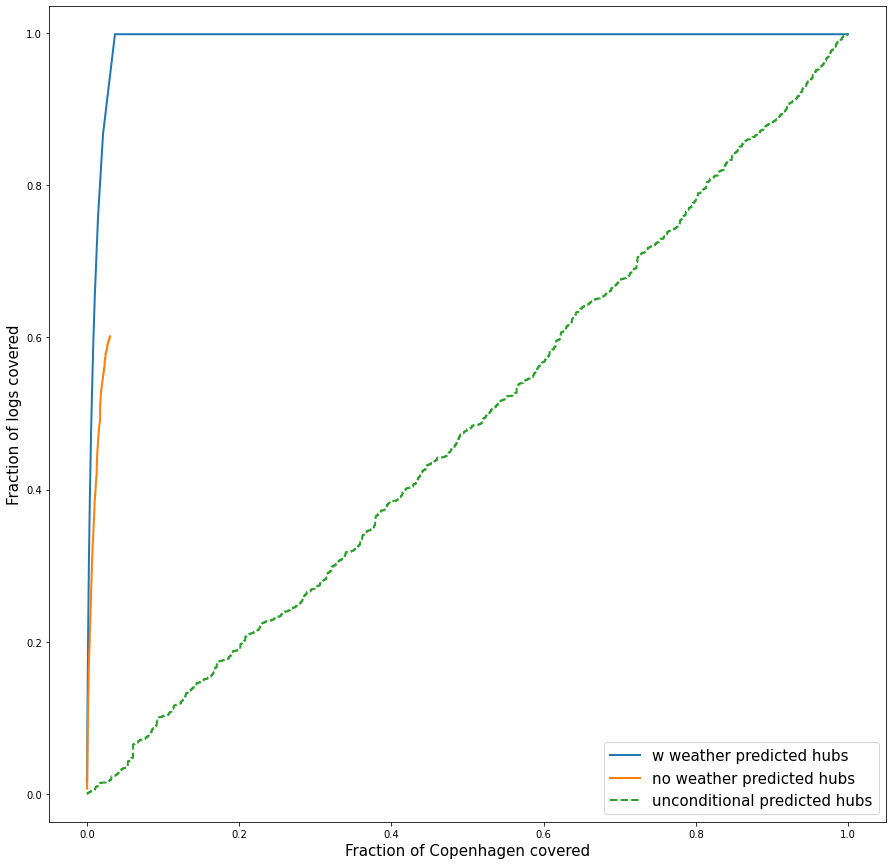

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')
#ax.plot(x, conditional_w_weather_covered_arr, linewidth=2)
#ax.plot(x, conditional_no_weather_covered_arr, linewidth=2)
#ax.plot(x, unconditional_covered_arr, linewidth=2)
x = np.linspace(0,1, 40000)
ax.plot(x, perfect_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x, random_percent_covered_arr, '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='lower right', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

Text(0, 0.5, 'Fraction of logs covered')

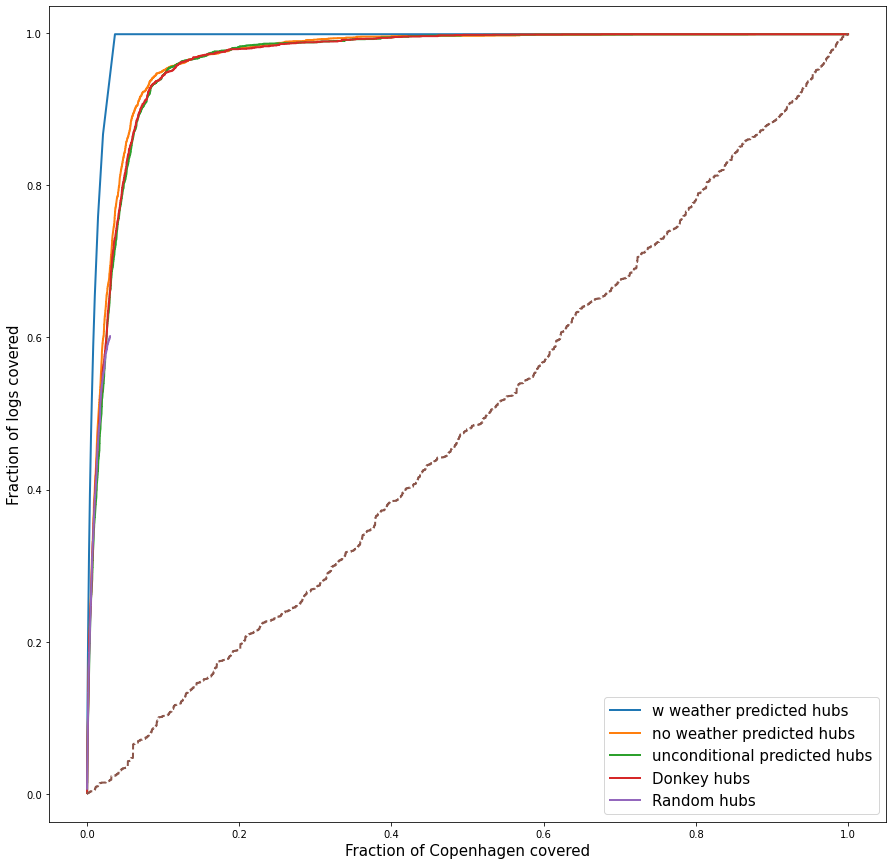

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')
ax.plot(x, perfect_covered_arr, linewidth=2)
ax.plot(x, conditional_w_weather_covered_arr, linewidth=2)
ax.plot(x, conditional_no_weather_covered_arr, linewidth=2)
ax.plot(x, unconditional_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x, random_percent_covered_arr, '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='lower right', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

Text(0, 0.5, 'Fraction of logs covered')

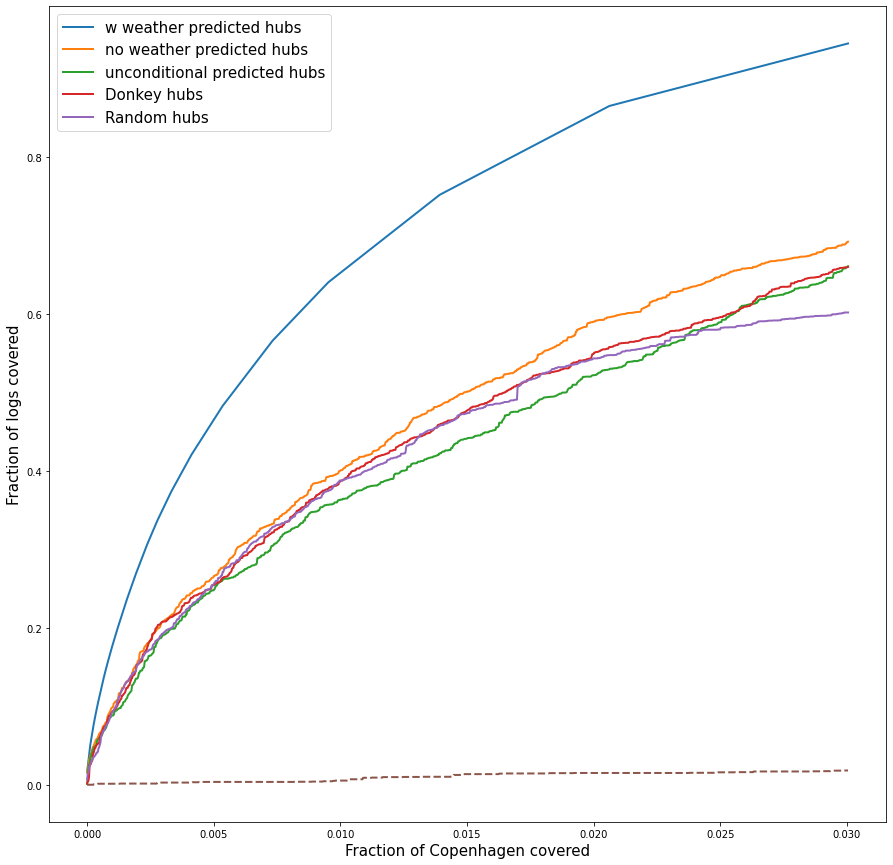

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(x[:n_hubs], perfect_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], conditional_w_weather_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], conditional_no_weather_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], unconditional_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], random_percent_covered_arr[:n_hubs], '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='upper left', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

# CAP test when conditioned on rain

# On hour and not rain

### Setup CAP data - SET CONTEXT HERE

In [0]:
train_idx, test_idx = get_split_idx_on_day(donkey_df)

In [0]:
train_dataloader, test_dataloader, extra_dataloader, obs_scaler, semisup_context_scaler, sup_context_scaler = searchlog_semisup_day_split(sup_df=donkey_df,
                                                                                                                                          unsup_df=extra_df,
                                                                                                                                          obs_cols=obs_cols,
                                                                                                                                          semisup_context_cols=weather_semisup_context_cols,
                                                                                                                                          sup_context_cols=weather_sup_context_cols,
                                                                                                                                          batch_size=batch_size,
                                                                                                                                          cuda_exp=True)

In [0]:
no_weather_semisup_context_cols

['hour_sin', 'hour_cos']

In [0]:
hour_test = 8
rain = False

hour_cos, hour_sin = circle_transform(hour_test,24)
scaled_context_no_weather = semisup_context_scaler.transform([[hour_sin, hour_cos]])
scaled_context_w_weather = np.array([np.concatenate((scaled_context_no_weather[0], [rain]))])

In [0]:
test_df = donkey_df.loc[test_idx]
context_idx = (test_df.merge_date.dt.hour == hour_test) & (test_df.rain == rain)
context_filtered_df = test_df.loc[context_idx]

In [0]:
len(context_filtered_df)

4303

In [0]:
# Map settings
initial_location = [55.6775757, 12.579571639999999]
hub_map = folium.Map(width=500,height=500,location=initial_location, zoom_start=12)
lower_left = [55.578855, 12.368879]
upper_right = [55.785292, 12.746675]
bounds = [lower_left, upper_right]


# Condition conditional flows
conditioned_no_weather_flow = no_weather_flow.condition(torch.tensor(scaled_context).float().cuda())
conditioned_w_weather_flow = w_weather_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())

In [0]:
_, _, _, conditional_w_weather_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_w_weather_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [01:45, 379.65it/s]


In [0]:
_, _, _, conditional_no_weather_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_no_weather_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [01:44, 383.43it/s]


In [0]:
_, _, _, unconditional_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=uncond_flow.dist, df=context_filtered_df, obs_scaler=obs_scaler) 

40000it [01:44, 383.06it/s]


In [0]:
_, _, _, hubs_covered_arr = calculate_cap_of_hubs(shape=(200,200), bounds=bounds, logs_df=context_filtered_df, hubs_df=hubs_df, ranked_hubs_df=ranked_hubs_df)

1203it [00:03, 372.16it/s]


In [0]:
_, _, _, random_percent_covered_arr = calculate_cap_of_random(shape=(200,200), bounds=bounds, dist=uncond_flow.dist, df=context_filtered_df, obs_scaler=obs_scaler) # note dist not actually used here just copy pasted code

40000it [02:46, 240.46it/s]


In [0]:
n_hubs = len(hubs_covered_arr)

Text(0, 0.5, 'Fraction of logs covered')

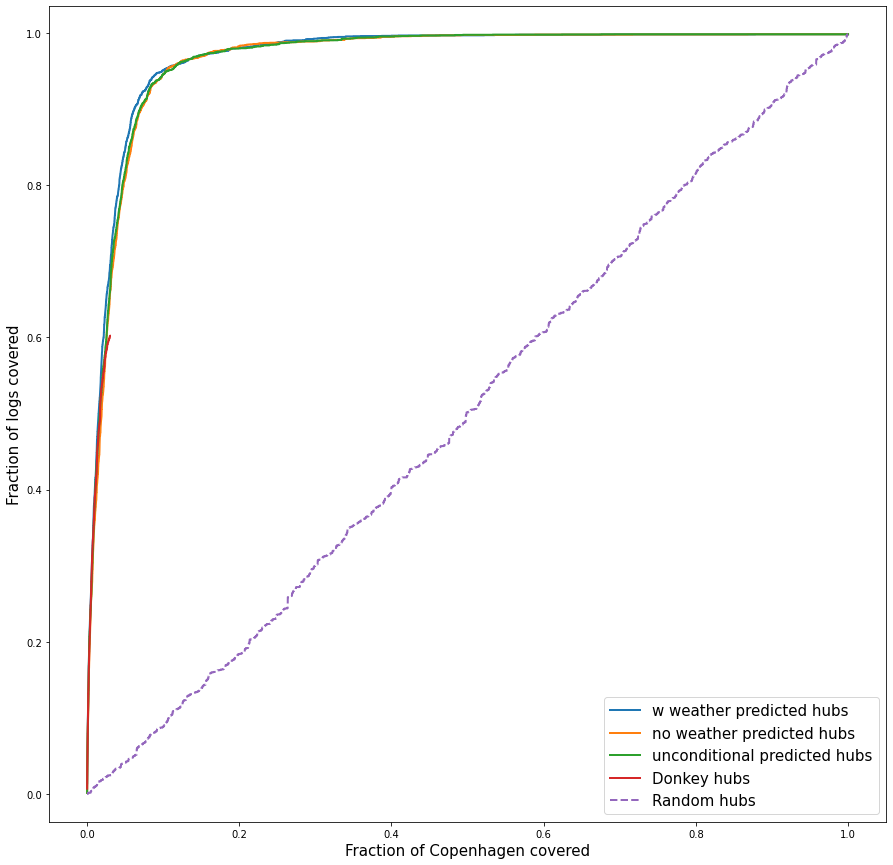

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')
ax.plot(x, conditional_w_weather_covered_arr, linewidth=2)
ax.plot(x, conditional_covered_arr, linewidth=2)
ax.plot(x, unconditional_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x, random_percent_covered_arr, '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='lower right', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

Text(0, 0.5, 'Fraction of logs covered')

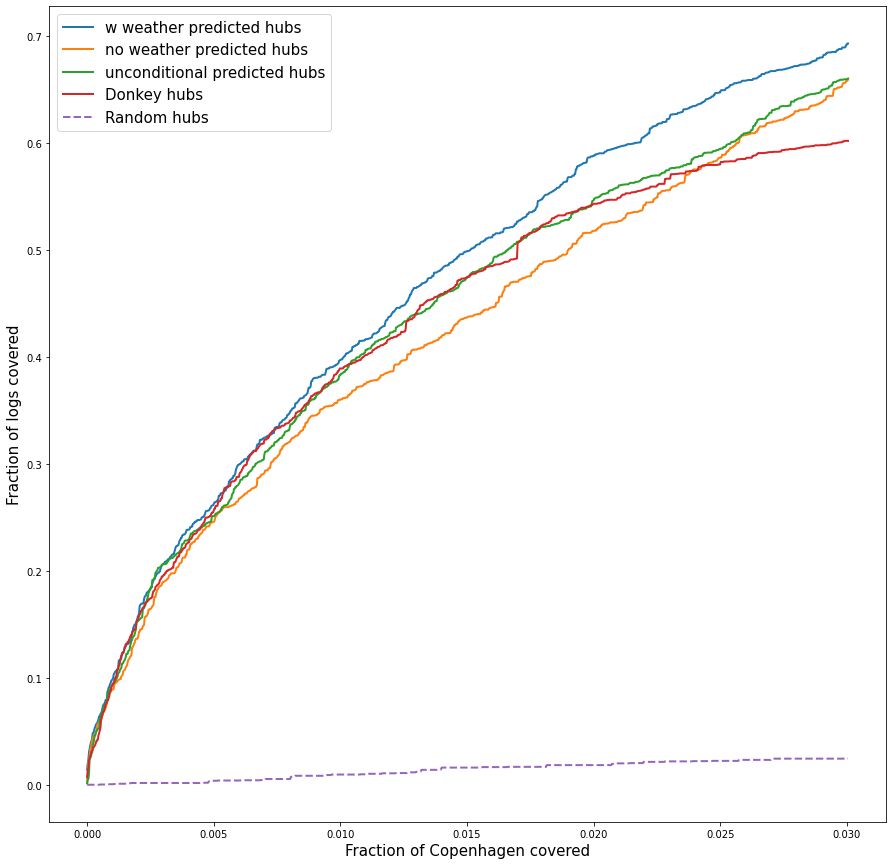

In [0]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(x[:n_hubs], conditional_w_weather_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], conditional_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], unconditional_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], random_percent_covered_arr[:n_hubs], '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='upper left', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

# On hour and not raining

### Setup CAP data - SET CONTEXT HERE

In [0]:
train_idx, test_idx = get_split_idx_on_day(donkey_df)

In [0]:
train_dataloader, test_dataloader, extra_dataloader, obs_scaler, semisup_context_scaler, sup_context_scaler = searchlog_semisup_day_split(sup_df=donkey_df,
                                                                                                                                          unsup_df=extra_df,
                                                                                                                                          obs_cols=obs_cols,
                                                                                                                                          semisup_context_cols=weather_semisup_context_cols,
                                                                                                                                          sup_context_cols=weather_sup_context_cols,
                                                                                                                                          batch_size=batch_size,
                                                                                                                                          cuda_exp=True)

In [0]:
no_weather_semisup_context_cols

['hour_sin', 'hour_cos']

In [0]:
hour_test = 8
rain = True

hour_cos, hour_sin = circle_transform(hour_test,24)
scaled_context_no_weather = semisup_context_scaler.transform([[hour_sin, hour_cos]])
scaled_context_w_weather = np.array([np.concatenate((scaled_context_no_weather[0], [rain]))])

In [0]:
test_df = donkey_df.loc[test_idx]
context_idx = (test_df.merge_date.dt.hour == hour_test) & (test_df.rain == rain)
context_filtered_df = test_df.loc[context_idx]

In [0]:
len(context_filtered_df)

432

In [0]:
# Map settings
initial_location = [55.6775757, 12.579571639999999]
hub_map = folium.Map(width=500,height=500,location=initial_location, zoom_start=12)
lower_left = [55.578855, 12.368879]
upper_right = [55.785292, 12.746675]
bounds = [lower_left, upper_right]


# Condition conditional flows
conditioned_no_weather_flow = no_weather_flow.condition(torch.tensor(scaled_context).float().cuda())
conditioned_w_weather_flow = w_weather_flow.condition(torch.tensor(scaled_context_w_weather).float().cuda())

In [0]:
_, _, _, conditional_w_weather_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_w_weather_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [01:44, 383.14it/s]


In [0]:
_, _, _, conditional_no_weather_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=conditioned_no_weather_flow, df=context_filtered_df, obs_scaler=obs_scaler)
x = np.linspace(0,1, 40000)

40000it [01:42, 390.23it/s]


In [0]:
_, _, _, unconditional_covered_arr = calculate_cap_of_model(shape=(200,200), bounds=bounds, dist=uncond_flow.dist, df=context_filtered_df, obs_scaler=obs_scaler) 

40000it [01:41, 393.55it/s]


In [0]:
_, _, _, hubs_covered_arr = calculate_cap_of_hubs(shape=(200,200), bounds=bounds, logs_df=context_filtered_df, hubs_df=hubs_df, ranked_hubs_df=ranked_hubs_df)

1203it [00:03, 368.04it/s]


In [0]:
_, _, _, random_percent_covered_arr = calculate_cap_of_random(shape=(200,200), bounds=bounds, dist=uncond_flow.dist, df=context_filtered_df, obs_scaler=obs_scaler) # note dist not actually used here just copy pasted code

40000it [02:41, 247.27it/s]


In [0]:
n_hubs = len(hubs_covered_arr)

Text(0, 0.5, 'Fraction of logs covered')

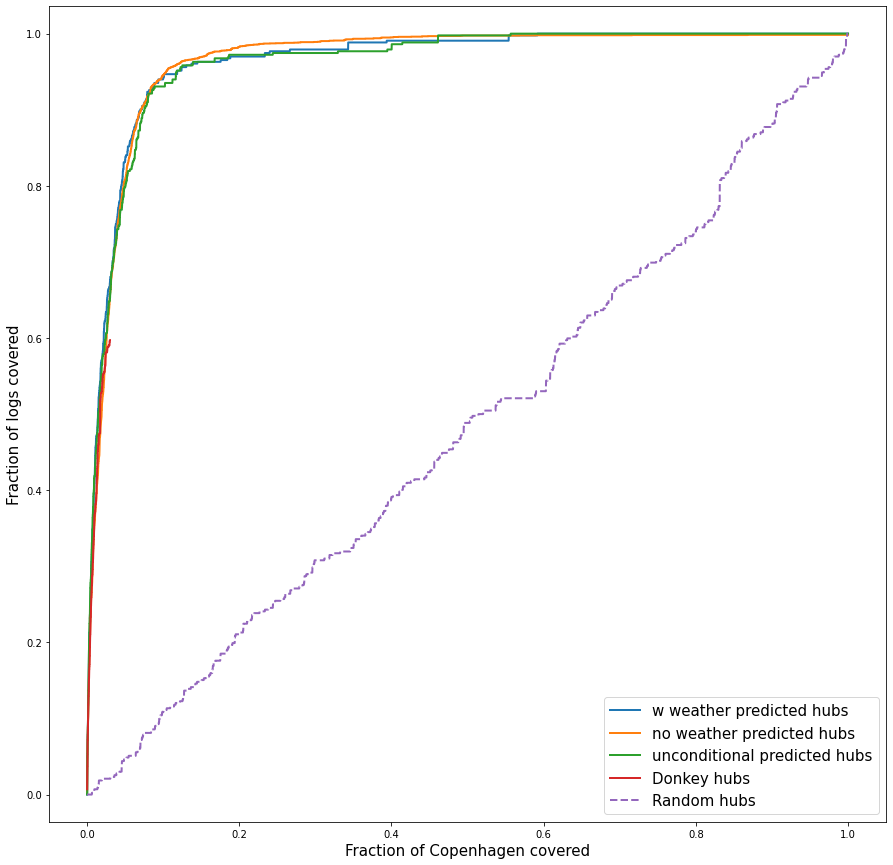

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
ax.axis('equal')
ax.plot(x, conditional_w_weather_covered_arr, linewidth=2)
ax.plot(x, conditional_covered_arr, linewidth=2)
ax.plot(x, unconditional_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x, random_percent_covered_arr, '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='lower right', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

Text(0, 0.5, 'Fraction of logs covered')

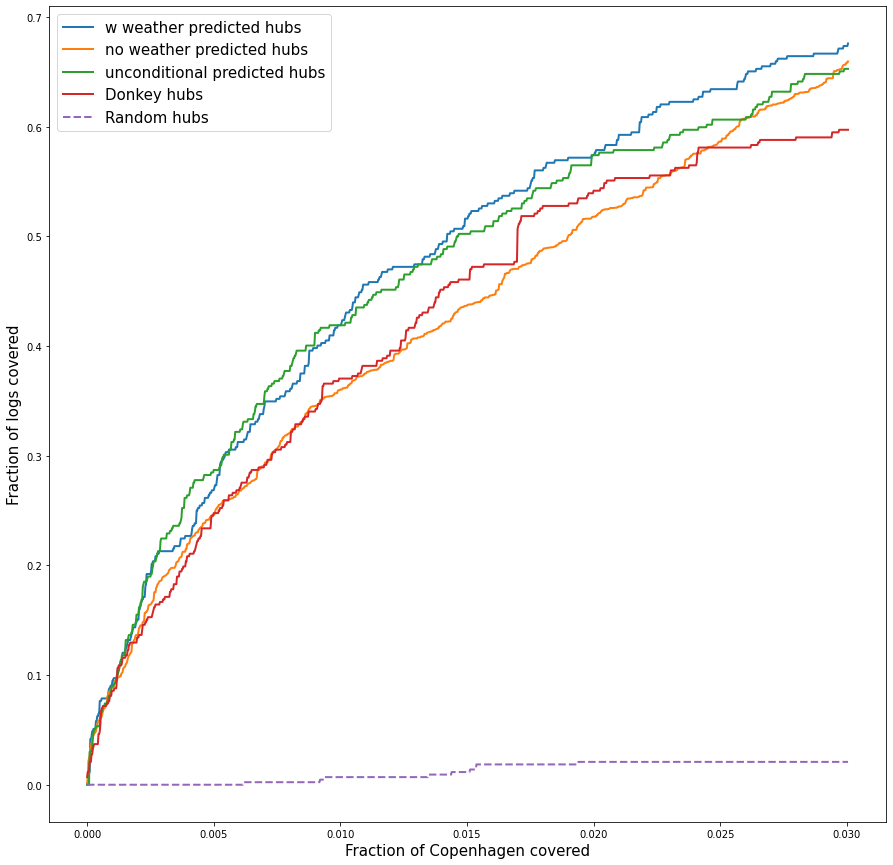

In [0]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(x[:n_hubs], conditional_w_weather_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], conditional_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], unconditional_covered_arr[:n_hubs], linewidth=2)
ax.plot(x[:n_hubs], hubs_covered_arr, linewidth=2)
ax.plot(x[:n_hubs], random_percent_covered_arr[:n_hubs], '--', linewidth=2)
ax.legend(['w weather predicted hubs', 'no weather predicted hubs', 'unconditional predicted hubs', 'Donkey hubs', 'Random hubs'], loc='upper left', fontsize=15, markerscale=4)
ax.set_xlabel('Fraction of Copenhagen covered', fontsize=15)
ax.set_ylabel('Fraction of logs covered', fontsize=15)

# TEMP

In [0]:
def create_points_df(shape, bounds):
    nlats, nlons = shape
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats)
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons)
    delta_lat = abs((lats_array[1] - lats_array[0]).item())
    delta_lon = abs((lons_array[1] - lons_array[0]).item())
    x, y = torch.meshgrid(lats_array, lons_array)
    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1)
    point_dict = {'latitude': points[:, 0], 'longitude': points[:, 1]}
    point_df = pd.DataFrame(point_dict)

    return point_df, delta_lat, delta_lon

def calculate_cap_of_perfect_model(shape, bounds, df):
    points_df, delta_lat, delta_lon = create_points_df(shape,bounds)
    cumulative_covered = 0
    n_covered_arr = []
    percent_covered_arr = []
    n_logs = len(df)
    for index, row in tqdm(points_df.iterrows()):
        point = row.loc[['latitude', 'longitude']].values

        # Find points covered by this hub
        in_lat = (df['user_location_latitude'] >= (point[0] - delta_lat/2)) & (df['user_location_latitude'] < (point[0] + delta_lat/2))
        in_lon = (df['user_location_longitude'] >= (point[1] - delta_lon/2)) & (df['user_location_longitude'] < (point[1] + delta_lon/2))
        in_cover = in_lat & in_lon

        # Calculate how many points is covered
        covered_idxs = in_cover[in_cover].index
        n_covered = len(covered_idxs)
        n_covered_arr.append(n_covered)
        df = df.drop(covered_idxs)

    points_df['n_covered'] = n_covered_arr
    points_df = points_df.sort_values('n_covered', ascending=False)
    for index, row in tqdm(points_df.iterrows()):
        cumulative_covered += row['n_covered']
        percent_covered = cumulative_covered / n_logs
        percent_covered_arr.append(percent_covered)
        
    max_points_arr = points_df[['latitude','longitude']].values
    n_covered_arr = points_df['n_covered'].values 

    return max_points_arr, n_covered_arr, percent_covered_arr